# Set-up

## Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.decomposition import NMF

from utils import plot_components, normalize_curves
from lcnmf import LCNMF, _loss_nmf, _loss_constraint_c, _loss_constraint_s
from blind_separation import get_curves_info, process_sector_consumption, get_indicators, get_Y, get_B, get_D, initialize_C

In [2]:
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [3]:
curves_infile = 'data/daily_curves_2021_2022_2023.csv'
consumption_file = 'data/1_input/consumption/consumption.xlsx'
imser_file = 'data/1_input/indicators/IMSER.xlsx'
imcei_file = 'data/1_input/indicators/IMCEI_mensile.xlsx'
enel_files = [
    'data/1_input/indicators/Domestico 2020 e 2021.xlsx', 
    'data/1_input/indicators/Domestico 2022 e 2023.xlsx'
]

n_components = 5

## Functions

# Create matrices for LCNMF

$$
(\hat{C}, \hat{S}) = \text{argmin}_{C \in \mathbb{R}_+^{n \times K},\, S \in \mathbb{R}_+^{K \times p}} \,
\left\lVert X - C S \right\rVert_{F}^2 +
\alpha \left\lVert B C A - Y \right\rVert_{F}^2 +
\beta \left\lVert E S D - Z \right\rVert_{F}^2
$$

## Data matrix $X$

In [4]:
curves_df = pd.read_csv(curves_infile, index_col=0)
curves_info = get_curves_info(curves_df)
X = normalize_curves(curves_df)
n, p = X.shape
X

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,0.040803,0.038886,0.035334,0.033238,0.031889,0.032188,0.033692,0.034905,0.035071,0.037756,...,0.042926,0.043763,0.048017,0.049442,0.050427,0.050274,0.047813,0.045368,0.041204,0.037392
Italy_2021-01-02_Saturday,0.034582,0.031817,0.030355,0.029420,0.029645,0.030477,0.033313,0.035742,0.038388,0.041735,...,0.044692,0.045697,0.050693,0.052824,0.053599,0.051233,0.047675,0.044239,0.039821,0.035934
Italy_2021-01-03_Holiday,0.037136,0.034000,0.032340,0.031203,0.030766,0.031843,0.033620,0.035059,0.036471,0.040169,...,0.043728,0.044653,0.049015,0.050888,0.053074,0.052575,0.048646,0.045187,0.041296,0.037256
Italy_2021-01-04_Monday,0.029418,0.027064,0.025802,0.025455,0.025877,0.027024,0.031138,0.037437,0.043145,0.047889,...,0.049408,0.049332,0.051916,0.052597,0.052436,0.049890,0.045963,0.041847,0.037930,0.033916
Italy_2021-01-05_Working day,0.032700,0.029969,0.028335,0.027614,0.027737,0.028593,0.032544,0.038216,0.043890,0.047585,...,0.048687,0.048577,0.051137,0.050909,0.049935,0.047810,0.044150,0.040411,0.036294,0.032685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-27_Working day,0.031215,0.028376,0.027110,0.026430,0.026568,0.028107,0.032785,0.038809,0.044172,0.048846,...,0.048532,0.048145,0.051412,0.051851,0.052040,0.049940,0.046330,0.041810,0.037424,0.033329
Italy_2023-12-28_Working day,0.032689,0.030026,0.028314,0.027766,0.027723,0.029131,0.033420,0.039017,0.044030,0.048189,...,0.047351,0.047791,0.051256,0.051045,0.051089,0.049059,0.045432,0.040899,0.036295,0.032124
Italy_2023-12-29_Working day,0.033475,0.030587,0.029154,0.028495,0.028469,0.029772,0.033516,0.038696,0.043329,0.047580,...,0.046808,0.046989,0.050406,0.050990,0.051189,0.048770,0.045398,0.041513,0.037268,0.033290
Italy_2023-12-30_Saturday,0.035726,0.032823,0.031132,0.030366,0.030215,0.031228,0.033963,0.038017,0.041096,0.044885,...,0.044174,0.045590,0.050556,0.052643,0.053819,0.052008,0.047992,0.044299,0.040412,0.036058


## Create ASC and MSI matrix $\mathrm{Y}$

In [5]:
year_totals = curves_info.groupby('year')['cons'].sum()
year_month_totals = curves_info.groupby(['year', 'month'])['cons'].sum()

cons_df = process_sector_consumption(consumption_file, year_totals)
indics_df = get_indicators(imser_file, imcei_file, enel_files)

Y = get_Y(indics_df, cons_df, year_month_totals)
Y

,Domestic,Industry,Services
Mese,,,
2021-01-01,7264.327172,11890.104760,7927.437550
2021-02-01,5771.093106,12075.604048,7132.053379
2021-03-01,5767.962408,13569.650603,7332.034509
2021-04-01,5046.757258,12703.446330,6746.118914
2021-05-01,4169.891321,13609.043673,7202.643509
2021-06-01,5084.753458,13538.940904,8798.173158
2021-07-01,6442.223202,13902.126207,10089.506106
2021-08-01,8235.942800,8911.761914,9523.402825
2021-09-01,4985.746719,13464.312971,8535.784303


## Create parameter matices $\mathrm{B}$ and $\mathrm{A}$

In [6]:
B = get_B(curves_df)
B

,Italy_2021-01-01_Holiday,Italy_2021-01-02_Saturday,Italy_2021-01-03_Holiday,Italy_2021-01-04_Monday,Italy_2021-01-05_Working day,Italy_2021-01-06_Holiday,Italy_2021-01-07_Working day,Italy_2021-01-08_Working day,Italy_2021-01-09_Saturday,Italy_2021-01-10_Holiday,...,Italy_2023-12-22_Working day,Italy_2023-12-23_Saturday,Italy_2023-12-24_Holiday,Italy_2023-12-25_Holiday,Italy_2023-12-26_Holiday,Italy_2023-12-27_Working day,Italy_2023-12-28_Working day,Italy_2023-12-29_Working day,Italy_2023-12-30_Saturday,Italy_2023-12-31_Holiday
2021-01,612.349503,662.107498,640.667495,811.363504,841.526504,721.363001,924.750503,948.432509,799.0985,721.477,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2021-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2021-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2021-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2021-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2021-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2021-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2021-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2021-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2021-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.000000,0.000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000


In [7]:
A = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1]
])

## Specify $\mathrm{E}$, $\mathrm{D}$ and $\mathrm{Z}$ matrices for constraints on $S$

In [8]:
E = np.eye(n_components)
Z = np.ones((n_components, 1))

# Creating matrix D is a little more complicated as the multiplication of each row of S with the column matrix D should give the functional norm
# The lines below essentially consist in writing the functional_norm as a vectorized function
D = get_D(p)

# Find suitable $\alpha$ and $\beta$ regularisation parameters

## Search $\alpha$ and $\beta$

In [9]:
C_init = initialize_C(X, n_components)
S_init = normalize_curves(np.ones((n_components, p)))

loss_nmf = _loss_nmf(X, C_init, S_init)
loss_constraint_c = _loss_constraint_c(Y, B.values, C_init, A)
loss_constraint_s = _loss_constraint_s(Z, E, S_init, D)

print(loss_nmf, loss_constraint_c, loss_constraint_s)
print(loss_nmf / loss_constraint_c)

1.4110517837693108 2948632555.826024 1.232595164407831e-32
4.785444632568067e-10


In [10]:
# The term that beta controls is the sum of n_component deviations from the unit-functional-normed vector, so we can safely set it to 1 or 0.1
beta = 1

In [11]:
### Search for alphas ###

n_alphas = 20
pow_min = -11
pow_max = -8
alphas = 10 ** np.linspace(pow_min, pow_max, n_alphas)
# alphas = np.linspace(1e-10, 1e-9, n_alphas) # for uniform initilisation 5 components
# alphas = np.linspace(5e-10, 5e-9, n_alphas) # for uniform initilisation 3 components
n_runs = 10

n_iter_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_nmf_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_constraint_c_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_constraint_s_df = pd.DataFrame(columns=alphas, index=range(n_runs))

for alpha in tqdm(alphas):
    n_iter = []
    loss_nmf = []
    loss_constraint_c = []
    loss_constraint_s = []

    model = LCNMF(
        n_components=n_components,
        alpha=alpha,
        beta=beta
    )

    for runs in range(n_runs):
        C_init = initialize_C(X, n_components)
        C = model.fit_transform(X.values, C_init.values, S_init, Y.values, A, B.values, Z, D, E)

        n_iter.append(model.n_iter_)
        loss_nmf.append(model.losses_nmf_[-1])
        loss_constraint_c.append(model.losses_constraint_c_[-1])
        loss_constraint_s.append(model.losses_constraint_s_[-1])
    
    n_iter_df[alpha] = n_iter
    loss_nmf_df[alpha] = loss_nmf
    loss_constraint_c_df[alpha] = loss_constraint_c
    loss_constraint_s_df[alpha] = loss_constraint_s


100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


<Axes: >

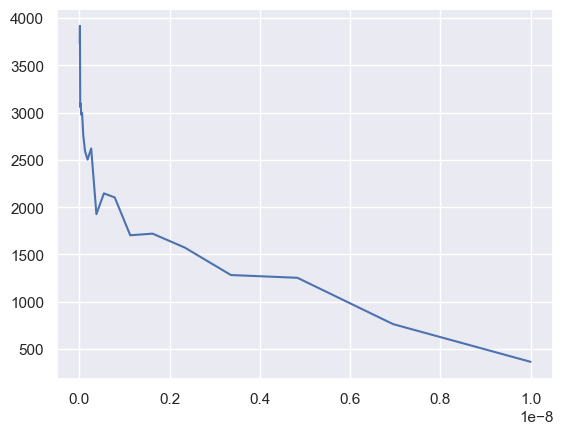

In [12]:
n_iter_df.mean(axis=0).plot()

<Axes: >

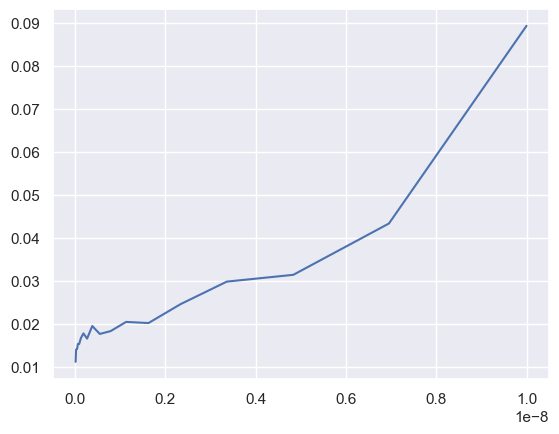

In [13]:
loss_nmf_df.mean(axis=0).plot()

<Axes: >

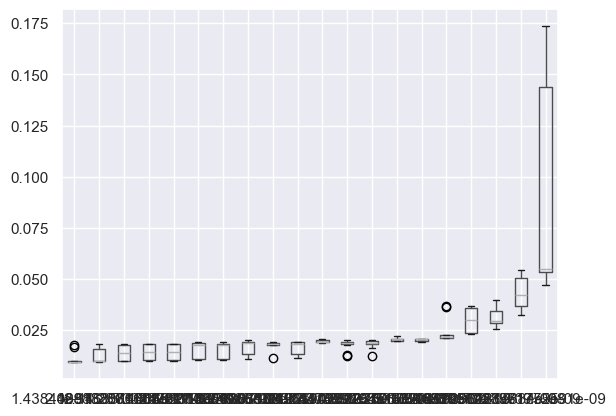

In [14]:
loss_nmf_df.boxplot()

In [15]:
loss_nmf_df.median(axis=0)

1.000000e-11    0.009647
1.438450e-11    0.009909
2.069138e-11    0.014012
2.976351e-11    0.014285
4.281332e-11    0.014106
6.158482e-11    0.017887
8.858668e-11    0.017771
1.274275e-10    0.018812
1.832981e-10    0.018326
2.636651e-10    0.018482
3.792690e-10    0.019343
5.455595e-10    0.018679
7.847600e-10    0.018862
1.128838e-09    0.020515
1.623777e-09    0.020529
2.335721e-09    0.021703
3.359818e-09    0.029982
4.832930e-09    0.029278
6.951928e-09    0.041950
1.000000e-08    0.055035
dtype: float64

In [16]:
loss_nmf_df

,1.000000e-11,1.438450e-11,2.069138e-11,2.976351e-11,4.281332e-11,6.158482e-11,8.858668e-11,1.274275e-10,1.832981e-10,2.636651e-10,3.792690e-10,5.455595e-10,7.847600e-10,1.128838e-09,1.623777e-09,2.335721e-09,3.359818e-09,4.832930e-09,6.951928e-09,1.000000e-08
0,0.009633,0.018024,0.010489,0.010227,0.010365,0.018615,0.010642,0.011177,0.019306,0.011592,0.018545,0.019084,0.020139,0.021912,0.020883,0.021969,0.035971,0.035051,0.051304,0.172989
1,0.016974,0.009948,0.010284,0.018138,0.017897,0.019031,0.018272,0.019112,0.018151,0.012071,0.019015,0.019227,0.012594,0.020955,0.020508,0.021196,0.036158,0.029390,0.054036,0.054941
2,0.009625,0.009869,0.010052,0.010647,0.018153,0.017448,0.018458,0.018972,0.018405,0.019207,0.020101,0.019509,0.018120,0.019889,0.019206,0.036894,0.023878,0.025819,0.043303,0.053506
3,0.009661,0.009754,0.017534,0.009893,0.018438,0.011124,0.018268,0.019161,0.018816,0.018520,0.020621,0.017997,0.019962,0.020395,0.020001,0.021137,0.035050,0.028215,0.032418,0.054127
4,0.017713,0.009763,0.017987,0.017924,0.010188,0.010819,0.010854,0.011324,0.011273,0.019105,0.019448,0.018516,0.019895,0.019925,0.019307,0.022023,0.023578,0.038230,0.054544,0.047109
5,0.009449,0.010153,0.017808,0.018253,0.010233,0.018326,0.011010,0.018857,0.017807,0.018658,0.019034,0.018552,0.018231,0.020635,0.020793,0.022740,0.036993,0.028979,0.036719,0.055128
6,0.009596,0.018007,0.009955,0.010291,0.017734,0.010589,0.018444,0.018718,0.017887,0.018444,0.019587,0.012197,0.018862,0.020889,0.019654,0.021330,0.034913,0.029165,0.047994,0.173420
7,0.009587,0.009643,0.009840,0.017986,0.018359,0.010791,0.017274,0.020168,0.019289,0.011908,0.020582,0.012841,0.020306,0.020006,0.020663,0.036440,0.023167,0.033283,0.035891,0.055363
8,0.009767,0.009835,0.018167,0.009914,0.010479,0.018548,0.010990,0.018767,0.019000,0.017104,0.019151,0.020193,0.016488,0.019500,0.020551,0.021437,0.023843,0.039724,0.040597,0.173618
9,0.010022,0.018071,0.018090,0.018339,0.010132,0.018533,0.019248,0.011066,0.018246,0.019431,0.019239,0.018806,0.018862,0.020767,0.020655,0.021042,0.025050,0.026523,0.036959,0.053202


<Axes: >

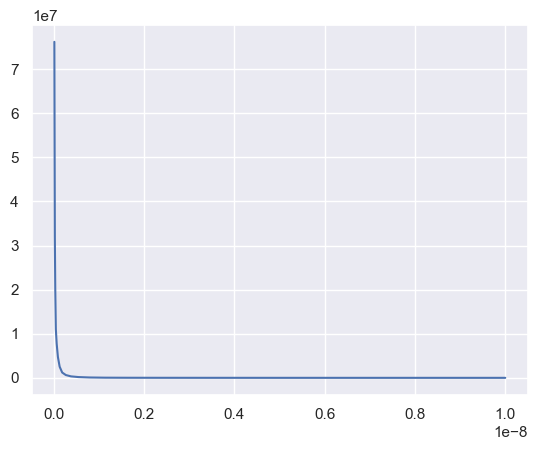

In [17]:
loss_constraint_c_df.mean(axis=0).plot()

<Axes: >

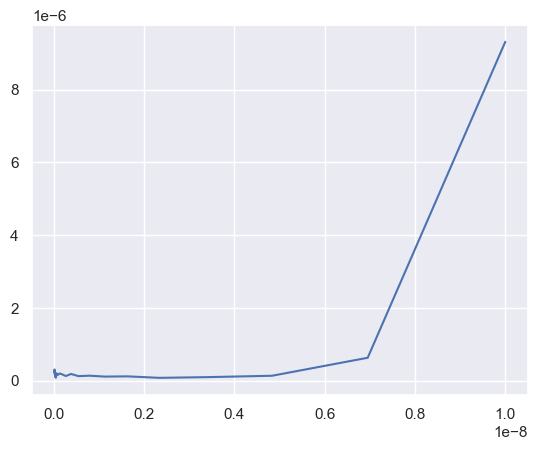

In [18]:
loss_constraint_s_df.mean(axis=0).plot()

Text(0.5, 0, 'alpha')

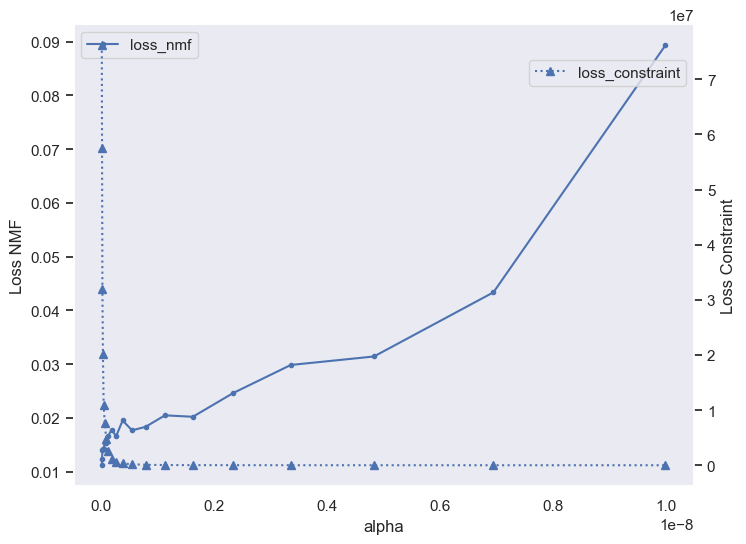

In [19]:
plt.figure(figsize=(8, 6))
ax1 = plt.gca()
loss_nmf_df.mean(axis=0).plot(ax=ax1, label='loss_nmf', marker='.')
ax1.grid(None)
ax1.legend()
ax1.set_ylabel('Loss NMF')

ax2 = ax1.twinx()
loss_constraint_c_df.mean(axis=0).plot(ax=ax2, label='loss_constraint', marker='^', linestyle='dotted')
ax2.grid(None)
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))
ax2.set_ylabel('Loss Constraint')
ax1.set_xlabel('alpha')
# plt.xlim((0, 1e-8))

In [20]:
loss_nmf = loss_nmf_df.mean(axis=0).values
loss_constraint_c = loss_constraint_c_df.mean(axis=0).values
loss_constraint_s = loss_constraint_s_df.mean(axis=0).values

# Create the hover text with indices
hover_text_nmf = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss NMF: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_nmf))]
hover_text_constraint_c = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss Constraint C: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_constraint_c))]
hover_text_constraint_s = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss Constraint S: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_constraint_s))]

# Create traces
trace1 = go.Scatter(
    x=alphas,
    y=loss_nmf,
    mode='lines+markers',
    name='Loss NMF',
    marker=dict(symbol='circle'),
    line=dict(shape='linear'),
    hovertemplate=hover_text_nmf
)

trace2 = go.Scatter(
    x=alphas,
    y=loss_constraint_c,
    mode='lines+markers',
    name='Loss Constraint C',
    marker=dict(symbol='triangle-up'),
    line=dict(shape='linear', dash='dot'),
    yaxis='y2',
    hovertemplate=hover_text_constraint_c
)

trace3 = go.Scatter(
    x=alphas,
    y=loss_constraint_s,
    mode='lines+markers',
    name='Loss Constraint S',
    marker=dict(symbol='diamond'),
    line=dict(shape='linear', dash='dot'),
    yaxis='y1',
    hovertemplate=hover_text_constraint_s
)


# Create layout
layout = go.Layout(
    title='Loss vs Alpha',
    xaxis=dict(
        title='Alpha',
        type='log',  # Use logarithmic scale for x-axis
        # range=[-8, -5],  # Adjust range for log scale
        showgrid=False
    ),
    yaxis=dict(
        title='Loss NMF',
    ),
    yaxis2=dict(
        title='Loss Constraint',
        overlaying='y',
        side='right'
    ),
    width=800,
    height=600,
    legend=dict(x=1, y=0.94)
)

# Create figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# pio.write_html(fig, file='plot.html', auto_open=True)

# Show plot
fig.show()

## Check evolution of loss for selected $\alpha$ and $\beta$

In [29]:
tol = 1e-5
max_iter = 10000
verbose = 0
alpha = 3e-10
beta = 1

model = LCNMF(
    n_components=n_components,
    alpha=alpha,
    beta=beta,
    tol=tol,
    max_iter=max_iter,
    verbose=0
)

S_init = normalize_curves(np.ones((n_components, p)))
C_init = initialize_C(X, n_components)

C = model.fit_transform(X, C_init.values, S_init, Y, A, B.values, Z, D, E)

Total loss:  0.018766226456343283

Loss NMF:  0.018646002756597835
Loss constraint:  400745.6658181575


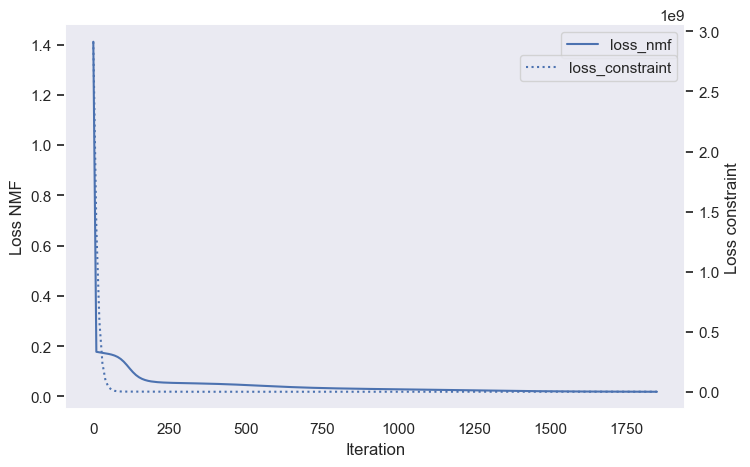

In [30]:
n_iter = model.n_iter_
losses_nmf = model.losses_nmf_
losses_constraint = model.losses_constraint_c_
# losses_constraint_s = model.losses_constraint_s_

plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax1.plot(np.arange(0, n_iter + 1, 10), losses_nmf, label='loss_nmf')
ax1.grid(None)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(np.arange(0, n_iter + 1, 10), losses_constraint, linestyle='dotted', label='loss_constraint')
ax2.grid(None)
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss NMF')
ax2.set_ylabel('Loss constraint')

print("Total loss: ", losses_nmf[-1] + alpha * losses_constraint[-1])
print("\nLoss NMF: ", losses_nmf[-1])
print("Loss constraint: ", losses_constraint[-1])

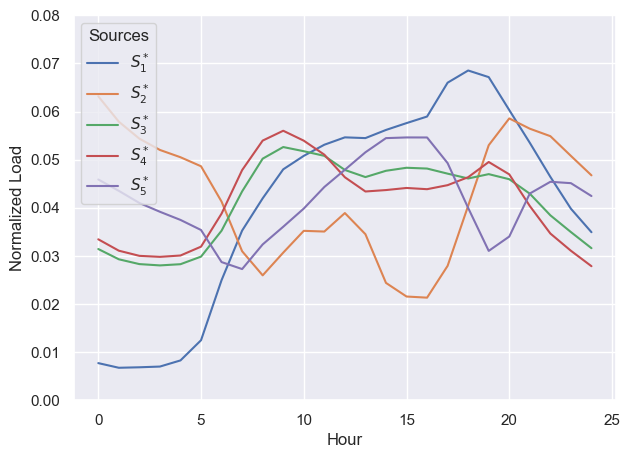

In [31]:
plot_components(model.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.08))

In [28]:
# Check L^1-norms
model.components_.dot(D)

array([[1.00275889],
       [1.00052726],
       [0.99869555],
       [1.00039364],
       [1.00036458]])

## Compare results with NMF

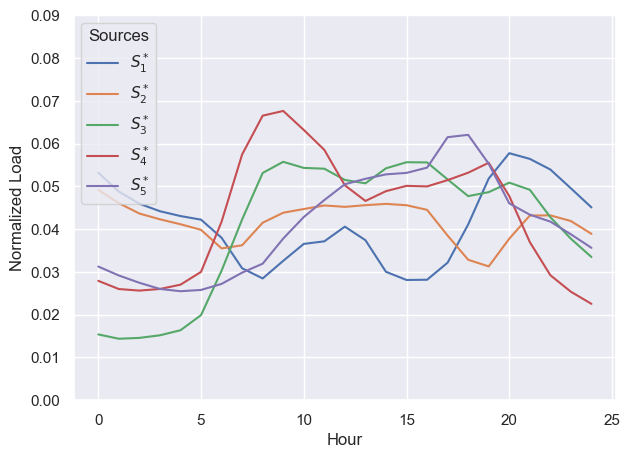

In [31]:
nmf = NMF(
        n_components=n_components,
        solver='mu',
        tol=tol,
        init='custom',
        max_iter=max_iter,
        verbose=verbose
)

C = nmf.fit_transform(
            X.values,
            W=C_init.values.copy(order='C'),
            H=S_init
        )

plot_components(nmf.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.09))

<Axes: >

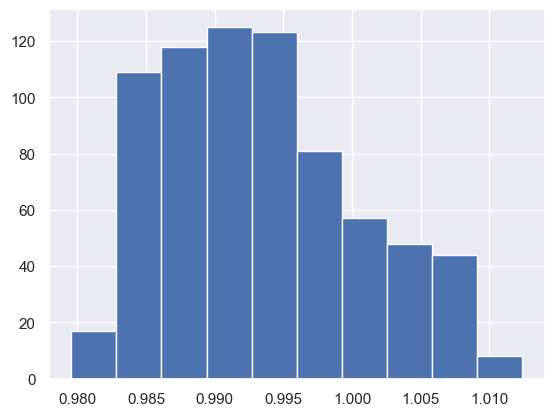

In [32]:
concentrations = pd.DataFrame(C, index=X.index)
concentrations.sum(axis=1).hist()

In [33]:
_loss_nmf(X, C, nmf.components_)

0.0059036222335898956

<HR>

# Tests